In [12]:
!pip install emoji


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import NLTKWordTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
# получим список стоп слов.
nltk_stop_words = set(stopwords.words("russian"))
#Lemmatizing the text
wnl = WordNetLemmatizer()

EMOTIONS = ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared', 'Surprised']



mlflow_url = 'http://localhost:8080'

# Функция для преобразования эмоджи в слова
def emojis_words(text):
    
    # Модуль emoji: преобразование эмоджи в их словесные описания
    clean_text = emoji.demojize(text, delimiters=(" ", " "))
    
    # Редактирование текста путём замены ":" и" _", а так же - путём добавления пробела между отдельными словами
    clean_text = clean_text.replace(":", "").replace("_", " ")
    
    return clean_text

# функция нормализации и очистки текста.
def cleaner(text :str) -> str:

    # Пунктуация
    text = re.sub(r'[.,#!$%\^&\*;:{}=\-_`~()]',r'',text)

     #Эмотиконы
    text =emojis_words(text)

    # #unicode
    # text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    # text = re.sub(r'[^\x00-\x7f]',r'',text)

    # url/ссылки
    text = re.sub(r'http\S+', r'', text)

    #теггирование/nicknames
    text = re.sub('@[A-Za-z0-9_-]+',r'',text)# nickname

    #хэштеги
    text = re.sub(r'#([^\s]+)', r'\1', text)

    #удалим цифры
    text = ''.join([i for i in text if not i.isdigit()])

    #приведем к нижнему регистру
    text = text.lower()

    #удалим стоп слова
    stop_words_cleaned = []
    for word in text.split():
      if word not in nltk_stop_words:
        stop_words_cleaned.append(word)

    text = ' '.join(stop_words_cleaned)

    #приведем текст к изначальной форме.
    text= ' '.join([wnl.lemmatize(word) for word in text.split()])

    return text

# ESKIS  ИМБП РАН

In [17]:
df_train = pd.read_csv('eskis_train.csv')
df_eval = pd.read_csv('eskis_eval.csv')
df_test = pd.read_csv('eskis_test.csv')

In [18]:
df_train = df_train.dropna()
df_eval = df_eval.dropna()
df_test = df_test.dropna()

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1650 entries, 0 to 1651
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       1650 non-null   object 
 1   Angry      1650 non-null   float64
 2   Disgusted  1650 non-null   float64
 3   Happy      1650 non-null   float64
 4   Neutral    1650 non-null   float64
 5   Sad        1650 non-null   float64
 6   Scared     1650 non-null   float64
 7   Surprised  1650 non-null   float64
dtypes: float64(7), object(1)
memory usage: 116.0+ KB


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 0 to 344
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       343 non-null    object 
 1   Angry      343 non-null    float64
 2   Disgusted  343 non-null    float64
 3   Happy      343 non-null    float64
 4   Neutral    343 non-null    float64
 5   Sad        343 non-null    float64
 6   Scared     343 non-null    float64
 7   Surprised  343 non-null    float64
dtypes: float64(7), object(1)
memory usage: 24.1+ KB


In [20]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 0 to 361
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       360 non-null    object 
 1   Angry      360 non-null    float64
 2   Disgusted  360 non-null    float64
 3   Happy      360 non-null    float64
 4   Neutral    360 non-null    float64
 5   Sad        360 non-null    float64
 6   Scared     360 non-null    float64
 7   Surprised  360 non-null    float64
dtypes: float64(7), object(1)
memory usage: 25.3+ KB


In [21]:
df_train = pd.concat([df_train, df_eval])

In [22]:
df_train['text'] = df_train['text'].apply(cleaner)
df_test['text'] = df_test['text'].apply(cleaner)

In [23]:
df_train.head(50)

,text,Angry,Disgusted,Happy,Neutral,Sad,Scared,Surprised
0,лебедева светлана шестнадцатое апреля одиннадц...,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,радиограмма совинкиной наверное бар коду пришл...,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,всем добрый день командир экипажа плуб флаг,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,всем добрый день командир экипажа вопросы возн...,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,числе папке типи регламента связи времени хоте...,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,нашли ячейку которая предприятии,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,отмечено баркодом нем пакете баркода,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,адресатов искать каждый фтп сервера,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8,самое главное должны обедать нашли тарелок тача,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,вилки номенклатуре базе тарелок,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df_eval['label'] = df_eval[EMOTIONS].values.argmax(axis=1)
label2emotion = {0: "Angry", 1: "Disgusted", 2: "Happy", 3: "Neutral", 4: "Sad", 5: "Scared", 6: "Surprised"}
dfe['emotion'] = df['label'].map(label2emotion)


TypeError: the first argument must be callable

In [41]:
df_eval["emotions"] = (df_eval[EMOTIONS] == 1).apply(
    lambda row: ", ".join(row[row].index), axis=1
)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss, classification_report, multilabel_confusion_matrix
import numpy as np

In [24]:
# 1. Подготовка данных
X_train = df_train['text']
y_train = df_train[EMOTIONS]
X_test = df_test['text']
y_test = df_test[EMOTIONS]


In [25]:
# 2. Векторизация текста
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [26]:

# 4. Обучение модели
model = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, class_weight='balanced')
).fit(X_train, y_train)

# 5. Предсказания
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# 6. Оценка качества
print(f"Hamming Loss: {hamming_loss(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=EMOTIONS))


Hamming Loss: 0.1070

Classification Report:
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         0
   Disgusted       0.22      0.30      0.26        37
       Happy       0.25      0.36      0.30        22
     Neutral       0.96      0.93      0.94       327
         Sad       0.10      0.20      0.13        15
      Scared       0.00      0.00      0.00         0
   Surprised       0.32      0.53      0.40        47

   micro avg       0.69      0.79      0.73       448
   macro avg       0.26      0.33      0.29       448
weighted avg       0.77      0.79      0.77       448
 samples avg       0.76      0.84      0.76       448



c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


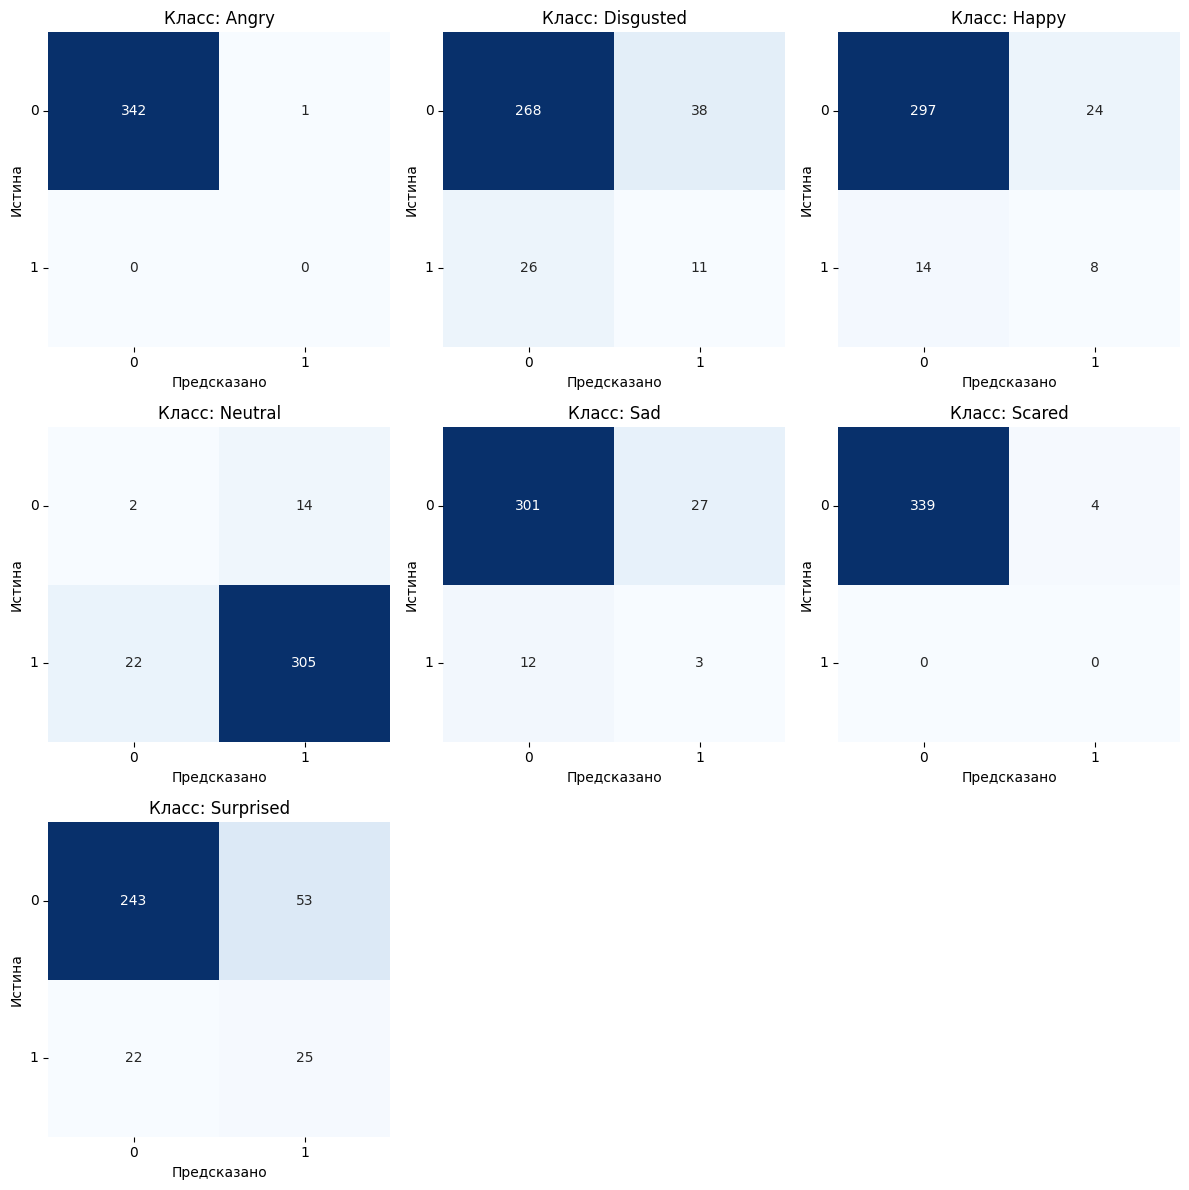

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Преобразуем DataFrame с истинными метками в numpy-массив.
# Предполагается, что y_test и y_pred имеют форму (n_samples, n_classes)
y_true_array = y_test.to_numpy()
y_pred_array = y_pred  # Предполагается, что y_pred уже в нужном виде

# Получаем имена классов из столбцов DataFrame (если они есть)
class_names = y_test.columns.tolist()

# Вычисляем многометочную confusion matrix для каждого класса
mcm = multilabel_confusion_matrix(y_true_array, y_pred_array)

# Определяем количество классов и настраиваем подграфики
n_classes = len(class_names)
n_cols = 3  # можно изменить число столбцов
n_rows = int(np.ceil(n_classes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

for i, (cm, class_name) in enumerate(zip(mcm, class_names)):
    # cm имеет форму 2x2 для каждого класса: [[TN, FP], [FN, TP]]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"Класс: {class_name}")
    axes[i].set_xlabel("Предсказано")
    axes[i].set_ylabel("Истина")
    axes[i].set_xticklabels(["0", "1"], rotation=0)
    axes[i].set_yticklabels(["0", "1"], rotation=0)

# Если подграфиков больше, чем классов, скрываем лишние оси
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [25]:
import evaluate
f1_metric = evaluate.load("f1")

In [ ]:
# import matplotlib.pyplot as plt
# from IPython import display 
# from tqdm import tqdm

# # Инициализация интерактивного режима
# plt.ion()
# fig, ax = plt.subplots(figsize=(12, 6))
# batch_losses = []
# global_step = 0
# # Получаем общее количество примеров
# total_samples = len(df_train)

# # Start an MLflow run
# with mlflow.start_run():
#     mlflow.log_params({
#     'batch_size': BATCH_SIZE,
#     'learning_rate': LEARNING_RATE,
#     'epochs': EPOCHS
#     })
#     # Модифицированный цикл обучения
#     for epoch in tqdm(range(EPOCHS)):
#         model.train()
#         epoch_train_loss = 0
#         epoch_samples = 0  # Счетчик примеров в эпохе
        
#         for batch_num, batch in enumerate(train_loader):
#             optimizer.zero_grad()
            
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)

#             outputs = model(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 labels=labels
#             )

#             loss = outputs.loss
#             epoch_train_loss += loss.item()
            
#             loss.backward()
#             optimizer.step()
            
#             # Обновление графика каждые 10 батчей
#             # Обновление счетчика примеров
#             batch_size = input_ids.size(0)
#             epoch_samples += batch_size
#             if batch_num % 10 == 0:
#                 batch_losses.append(loss.item())
                
#                 ax.clear()
#                 ax.plot(range(len(batch_losses)), batch_losses, 'b-', label='Batch Loss')
                
#                 # Форматирование заголовка с примером
#                 title = (
#                     f"Real-Time Training Loss | Epoch {epoch+1}/{EPOCHS}\n"
#                     f"Samples: {epoch_samples:,}/{total_samples:,} "
#                     f"({epoch_samples/total_samples*100:.1f}%)"
#                 )
#                 ax.set_title(title)
                
#                 ax.set_xlabel('Batch Groups (every 10 batches)')
#                 ax.set_ylabel('Loss')
#                 ax.grid(True)
#                 ax.legend()
                
#                 display.display(fig)  # Для Jupyter
#                 display.clear_output(wait=True)  # Для Jupyter
#                 # plt.pause(0.01)  # Для скрипта вне Jupyter
                
#             global_step += 1
#         # Log the hyperparameters
#         mlflow.log_metric('train_loss',  epoch_train_loss / len(train_loader), step=epoch)
        

#     # Log the model

#     mlflow.pytorch.log_model(model,"model")
#     mlflow.pytorch.save_model(model,"./sm")
#     # Визуализация после эпохи
#     avg_epoch_loss = epoch_train_loss / len(train_loader)
#     print(f'Epoch {epoch+1} completed | Avg Loss: {avg_epoch_loss:.4f}')

# plt.ioff()
# plt.show()

In [3]:
!pip install gputil

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7441 sha256=fefbe555b27d172a3decea058e81374670bd8d1932b6d46fc10c12e36424fe12
  Stored in directory: c:\users\rvv19\appdata\local\pip\cache\wheels\92\a8\b7\d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built gputil



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install pynvml


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
BASE_MODEL = 'sergeyzh/rubert-tiny-turbo'
mlflow_url = 'http://localhost:8080'
#EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
EMOTIONS = ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared', 'Surprised']
import mlflow
import numpy as np
import pandas as pd
import psutil
import GPUtil
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)
from transformers.integrations import MLflowCallback
from transformers import TrainerCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split



mlflow.set_tracking_uri(mlflow_url)
mlflow.set_experiment(f"ESKIS {BASE_MODEL} trans")
mlflow.enable_system_metrics_logging()

# -----------------------------
# Callback для логирования метрик в MLflow
# -----------------------------
class MLflowLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            for key, value in logs.items():
                mlflow.log_metric(key, value, step=state.global_step)
        return control

# -----------------------------
# Инициализация GPUtil для мониторинга GPU
# -----------------------------
try:
    gpus = GPUtil.getGPUs()
    gpu_available = len(gpus) > 0
except Exception as e:
    print("GPU monitoring not available:", e)
    gpu_available = False
    
# -----------------------------
# Callback для логирования системных метрик (CPU, RAM и GPU)
# -----------------------------
class SystemMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Логирование CPU и RAM
        cpu_percent = psutil.cpu_percent(interval=None)
        memory_percent = psutil.virtual_memory().percent
        mlflow.log_metric("system_cpu_percent", cpu_percent, step=state.global_step)
        mlflow.log_metric("system_memory_percent", memory_percent, step=state.global_step)
        
        # Логирование GPU метрик с использованием GPUtil, если доступны
        if gpu_available:
            try:
                gpus = GPUtil.getGPUs()
                if gpus:
                    gpu = gpus[0]
                    gpu_util = gpu.load * 100  # load возвращает значение от 0 до 1
                    gpu_memory_used_percent = gpu.memoryUtil * 100
                    mlflow.log_metric("gpu_utilization", gpu_util, step=state.global_step)
                    mlflow.log_metric("gpu_memory_used_percent", gpu_memory_used_percent, step=state.global_step)
            except Exception as e:
                print("Ошибка при получении GPU метрик:", e)
        return control


# Загрузка данных из CSV
#df = pd.read_csv("cedr.csv")

# -----------------------------
# 3. Преобразование one-hot меток в единую метку для многоклассовой классификации
# Предполагается, что ровно один из столбцов равен 1 для каждой строки
# -----------------------------

df['label'] = df[EMOTIONS].values.argmax(axis=1)
label2emotion = {0: "Angry", 1: "Disgusted", 2: "Happy", 3: "Neutral", 4: "Sad", 5: "Scared", 6: "Surprised"}
df['emotion'] = df['label'].map(label2emotion)

# Разбиение данных на обучающую и валидационную выборки (20% для валидации)
# Стратифицированное разбиение для сохранения пропорций классов
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42) #, stratify=df['label']
print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))

# -----------------------------
# 5. Создание объектов HuggingFace Dataset из pandas DataFrame
# -----------------------------
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

# -----------------------------
# 6. Инициализация токенизатора и токенизация текста
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

def tokenize_function(example):
    tokenized = tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)
    tokenized["label"] = example["label"]
    return tokenized

train_dataset = train_dataset.map(tokenize_function, batched=False)
val_dataset = val_dataset.map(tokenize_function, batched=False)

# Устанавливаем формат данных для работы с PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# -----------------------------
# 7. Инициализация модели для многоклассовой классификации (7 классов)
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=7)

# -----------------------------
# 8. Определение параметров обучения с промежуточным логированием (каждые 50 шагов)
# -----------------------------
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_dir='./logs',
    report_to=["mlflow"],  # Логирование только в MLflow
)

# -----------------------------
# 9. Определение функции вычисления метрик (accuracy)
# -----------------------------
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# -----------------------------
# 10. Запуск MLflow run
# -----------------------------
mlflow.start_run()

# -----------------------------
# 11. Создание Trainer с указанными параметрами и callback'ами
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[MLflowCallback(), MLflowLoggingCallback(), SystemMetricsCallback()],
)

# -----------------------------
# 12. Обучение модели
# -----------------------------
trainer.train()

# -----------------------------
# 13. Оценка модели на валидационном наборе
# -----------------------------
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# -----------------------------
# 14. Сохранение модели в MLflow
# -----------------------------
# mlflow.pytorch.log_model(model, "model")
# mlflow.pytorch.save_model(model,'./sm1')
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)
#mlflow.transformers.save_model(classifier,'./')
mlflow.transformers.log_model(classifier,'model')

mlflow.end_run()

# -----------------------------
# 15. Инференс: создание pipeline и пример предсказания
# -----------------------------
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)
example_text = "I am extremely joyful and happy today!"
prediction = classifier(example_text)
print("Prediction:", prediction)

# mlflow.transformers.save_model(classifier,'/smp')


Train set size: 2072
Validation set size: 519


Map:   0%|          | 0/2072 [00:00<?, ? examples/s]

Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sergeyzh/rubert-tiny-turbo and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
2025/03/29 00:21:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
You are adding a <class 'transformers.integrations.integration_utils.MLflowCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
MLflowCallback
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:440

Step,Training Loss,Validation Loss,Accuracy
50,1.699800,1.351600,0.797688
100,1.122400,0.838450,0.797688
150,0.868300,0.781196,0.797688
200,0.861000,0.767453,0.797688
250,0.817800,0.759858,0.797688
300,0.821300,0.754667,0.797688
350,0.866100,0.755703,0.797688
400,0.852700,0.754103,0.797688
450,0.807100,0.750135,0.797688
500,0.744600,0.749373,0.797688


Device set to use cuda:0


Evaluation results: {'eval_loss': 0.7478998899459839, 'eval_accuracy': 0.7976878612716763, 'eval_runtime': 0.2306, 'eval_samples_per_second': 2250.822, 'eval_steps_per_second': 281.895, 'epoch': 3.0}


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
2025/03/29 00:21:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/29 00:21:38 WARNING mlflow.utils.environment: On Windows, timeout is not supported for model requirement inference. Therefore, the operation is not bound by a timeout and may hang indefinitely. If it hangs, please consider specifying the signature manually.
2025/03/29 00:21:58 INFO mlf

Prediction: [[{'label': 'LABEL_0', 'score': 0.0177009180188179}, {'label': 'LABEL_1', 'score': 0.10470414906740189}, {'label': 'LABEL_2', 'score': 0.06181667745113373}, {'label': 'LABEL_3', 'score': 0.7868170142173767}, {'label': 'LABEL_4', 'score': 0.007435274310410023}, {'label': 'LABEL_5', 'score': 0.007028928957879543}, {'label': 'LABEL_6', 'score': 0.014496988616883755}]]


In [67]:
from sklearn.metrics import f1_score
# define which metrics to compute for evaluation
def compute_metrics(p):
    predictions, labels = p
    f1_micro = f1_score(labels, predictions > 0, average = 'micro')
    f1_macro = f1_score(labels, predictions > 0, average = 'macro')
    f1_weighted = f1_score(labels, predictions > 0, average = 'weighted')
    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

In [50]:
df_eval[EMOTIONS].values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
BASE_MODEL = 'sergeyzh/rubert-tiny-turbo'
mlflow_url = 'http://localhost:8080'

EMOTIONS = ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared', 'Surprised']
import mlflow
import numpy as np
import pandas as pd
import psutil
import GPUtil
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)
from transformers.integrations import MLflowCallback
from transformers import TrainerCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split



mlflow.set_tracking_uri(mlflow_url)
mlflow.set_experiment(f"ESKIS {BASE_MODEL} trans")
mlflow.enable_system_metrics_logging()

# -----------------------------
# Callback для логирования метрик в MLflow
# -----------------------------
class MLflowLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            for key, value in logs.items():
                mlflow.log_metric(key, value, step=state.global_step)
        return control

# -----------------------------
# Инициализация GPUtil для мониторинга GPU
# -----------------------------
try:
    gpus = GPUtil.getGPUs()
    gpu_available = len(gpus) > 0
except Exception as e:
    print("GPU monitoring not available:", e)
    gpu_available = False
    
# -----------------------------
# Callback для логирования системных метрик (CPU, RAM и GPU)
# -----------------------------
class SystemMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Логирование CPU и RAM
        cpu_percent = psutil.cpu_percent(interval=None)
        memory_percent = psutil.virtual_memory().percent
        mlflow.log_metric("system_cpu_percent", cpu_percent, step=state.global_step)
        mlflow.log_metric("system_memory_percent", memory_percent, step=state.global_step)
        
        # Логирование GPU метрик с использованием GPUtil, если доступны
        if gpu_available:
            try:
                gpus = GPUtil.getGPUs()
                if gpus:
                    gpu = gpus[0]
                    gpu_util = gpu.load * 100  # load возвращает значение от 0 до 1
                    gpu_memory_used_percent = gpu.memoryUtil * 100
                    mlflow.log_metric("gpu_utilization", gpu_util, step=state.global_step)
                    mlflow.log_metric("gpu_memory_used_percent", gpu_memory_used_percent, step=state.global_step)
            except Exception as e:
                print("Ошибка при получении GPU метрик:", e)
        return control


# df_eval["emotions"] = (df_eval[EMOTIONS] == 1).apply(
#     lambda row: ", ".join(row[row].index), axis=1
# )
# df_train["emotions"] = (df_train[EMOTIONS] == 1).apply(
#     lambda row: ", ".join(row[row].index), axis=1
# )

# df_train['label'] = df_train[EMOTIONS].values.argmax(axis=1)
# label2emotion = {0: "Angry", 1: "Disgusted", 2: "Happy", 3: "Neutral", 4: "Sad", 5: "Scared", 6: "Surprised"}
# df_train['emotion'] = df_train['label'].map(label2emotion)

# df_eval['label'] = df_eval[EMOTIONS].values.argmax(axis=1)
# df_eval['emotion'] = df_eval['label'].map(label2emotion)

df_train["labels"] = df_train[EMOTIONS].values.tolist()
df_eval["labels"] = df_eval[EMOTIONS].values.tolist()

# Для df_eval
df_eval["emotions"] = df_eval[EMOTIONS].apply(
    lambda row: ", ".join(f"{col}={int(val)}" for col, val in row.items()),
    axis=1
)

# Для df_train
df_train["emotions"] = df_train[EMOTIONS].apply(
    lambda row: ", ".join(f"{col}={int(val)}" for col, val in row.items()),
    axis=1
)
# -----------------------------
# 5. Создание объектов HuggingFace Dataset из pandas DataFrame
# -----------------------------
train_dataset = Dataset.from_pandas(df_train.reset_index(drop=True))
val_dataset = Dataset.from_pandas(df_eval.reset_index(drop=True))

# -----------------------------
# 6. Инициализация токенизатора и токенизация текста
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

def tokenize_function(example):
    tokenized = tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)
    tokenized["labels"] = example['labels']
    return tokenized

train_dataset = train_dataset.map(tokenize_function, batched=False)
val_dataset = val_dataset.map(tokenize_function, batched=False)

# Устанавливаем формат данных для работы с PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# -----------------------------
# 7. Инициализация модели для многоклассовой классификации (7 классов)
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=7,problem_type = "multi_label_classification")

# -----------------------------
# 8. Определение параметров обучения с промежуточным логированием (каждые 50 шагов)
# -----------------------------
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    logging_dir='./logs',
    report_to=["mlflow"],  # Логирование только в MLflow
)

# -----------------------------
# 9. Определение функции вычисления метрик (accuracy)
# -----------------------------
# accuracy_metric = evaluate.load("accuracy")
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return accuracy_metric.compute(predictions=predictions, references=labels)

# -----------------------------
# 10. Запуск MLflow run
# -----------------------------
mlflow.start_run()

# -----------------------------
# 11. Создание Trainer с указанными параметрами и callback'ами
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[MLflowCallback(), MLflowLoggingCallback(), SystemMetricsCallback()],
)

# -----------------------------
# 12. Обучение модели
# -----------------------------
trainer.train()

# -----------------------------
# 13. Оценка модели на валидационном наборе
# -----------------------------
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# -----------------------------
# 14. Сохранение модели в MLflow
# -----------------------------
# mlflow.pytorch.log_model(model, "model")
# mlflow.pytorch.save_model(model,'./sm1')
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)
#mlflow.transformers.save_model(classifier,'./')
mlflow.transformers.log_model(classifier,'model')

mlflow.end_run()

# -----------------------------
# 15. Инференс: создание pipeline и пример предсказания
# -----------------------------
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)
example_text = "I am extremely joyful and happy today!"
prediction = classifier(example_text)
print("Prediction:", prediction)

# mlflow.transformers.save_model(classifier,'/smp')


Map:   0%|          | 0/2010 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sergeyzh/rubert-tiny-turbo and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
2025/03/31 00:34:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
You are adding a <class 'transformers.integrations.integration_utils.MLflowCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
MLflowCallback


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted
50,0.622400,0.532586,0.803760,0.139194,0.678678
100,0.405900,0.323937,0.803760,0.139194,0.678678
150,0.307900,0.275478,0.803760,0.139194,0.678678
200,0.272700,0.254729,0.803760,0.139194,0.678678
250,0.245200,0.243362,0.803760,0.139194,0.678678
300,0.230300,0.237096,0.803760,0.139194,0.678678
350,0.230800,0.233094,0.803760,0.139194,0.678678
400,0.232500,0.231036,0.803760,0.139194,0.678678
450,0.233500,0.229557,0.803760,0.139194,0.678678
500,0.223100,0.228337,0.803760,0.139194,0.678678


Device set to use cuda:0


Evaluation results: {'eval_loss': 0.22452910244464874, 'eval_f1_micro': 0.8037602820211516, 'eval_f1_macro': 0.1391941391941392, 'eval_f1_weighted': 0.6786777377408741, 'eval_runtime': 0.202, 'eval_samples_per_second': 1782.122, 'eval_steps_per_second': 222.765, 'epoch': 5.0}


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
2025/03/31 00:35:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/03/31 00:35:17 WARNING mlflow.utils.environment: On Windows, timeout is not supported for model requirement inference. Therefore, the operation is not bound by a timeout and may hang indefinitely. If it hangs, please consider specifying the signature manually.
2025/03/31 00:35:26 INFO mlf

Prediction: [[{'label': 'LABEL_0', 'score': 0.02384822443127632}, {'label': 'LABEL_1', 'score': 0.10846539586782455}, {'label': 'LABEL_2', 'score': 0.07653889060020447}, {'label': 'LABEL_3', 'score': 0.9438319802284241}, {'label': 'LABEL_4', 'score': 0.054144665598869324}, {'label': 'LABEL_5', 'score': 0.018150513991713524}, {'label': 'LABEL_6', 'score': 0.14468638598918915}]]


In [ ]:
# mlflow.end_run()

2025/03/31 00:11:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run learned-gull-33 at: http://localhost:8080/#/experiments/810399883605539370/runs/008c1373ee61402194a43bc77334c9e5.
2025/03/31 00:11:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/810399883605539370.
2025/03/31 00:11:43 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/03/31 00:11:44 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Device set to use cuda:0
c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         0
   Disgusted       0.11      1.00      0.19        37
       Happy       0.00      0.00      0.00        22
     Neutral       0.95      1.00      0.98       327
         Sad       0.00      0.00      0.00        15
      Scared       0.00      0.00      0.00         0
   Surprised       0.14      1.00      0.24        47

   micro avg       0.40      0.92      0.56       448
   macro avg       0.17      0.43      0.20       448
weighted avg       0.72      0.92      0.75       448
 samples avg       0.40      0.94      0.55       448



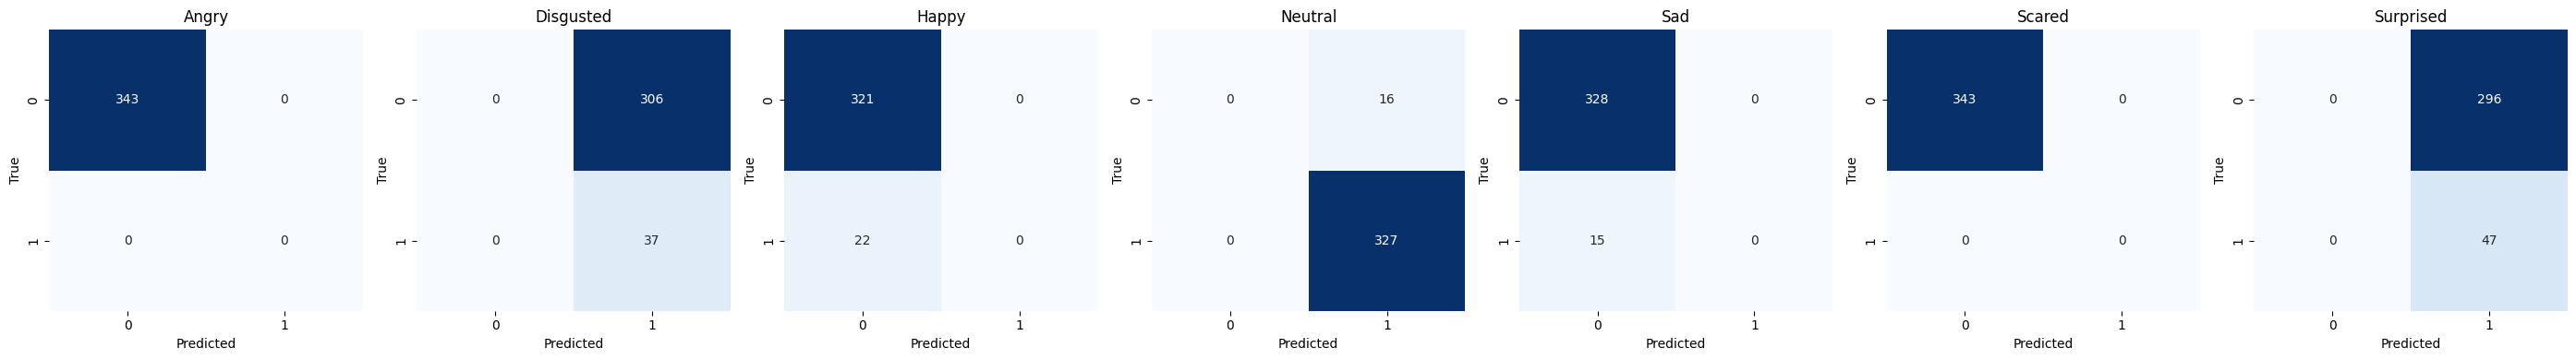

In [ ]:
import numpy as np
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Шаг 1: Определяем список эмоций (классов)
EMOTIONS = ['Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Scared', 'Surprised']

# Шаг 2: Создаём столбец "labels" с вектором 0/1 для каждой строки
df_test["labels"] = df_test[EMOTIONS].values.tolist()

# Шаг 3: Создаём pipeline для многометочной классификации
# (Предполагается, что model и tokenizer уже загружены/обучены)
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

# Списки для хранения предсказаний и истинных меток
predictions = []
true_labels = []

# Шаг 4: Инференс для каждой строки в df_test
for _, row in df_test.iterrows():
    text = row["text"]
    # Истинные метки (список из 7 элементов: 0 или 1)
    true_labels.append(row["labels"])
    
    # Вызываем pipeline на текст
    outputs = classifier(text)
    # outputs может быть списком словарей или списком списков словарей
    # Если вернулся список списков, берём первый элемент
    if isinstance(outputs[0], list):
        outputs = outputs[0]
        
    # Извлекаем score по каждому классу
    scores = [o["score"] for o in outputs]
    # Бинаризуем по порогу 0.5
    pred = [1 if s > 0.5 else 0 for s in scores]
    predictions.append(pred)

# Преобразуем в numpy массивы для удобства
y_true = np.array(true_labels)  # shape (num_samples, 7)
y_pred = np.array(predictions)  # shape (num_samples, 7)

# Шаг 5: Выводим отчёт классификации (precision, recall, f1-score) для каждого класса
report = classification_report(y_true, y_pred, target_names=EMOTIONS, zero_division=0)
print("Classification Report:\n", report)

# Шаг 6: Вычисляем и визуализируем многометочные confusion matrices
mcm = multilabel_confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, len(EMOTIONS), figsize=(4 * len(EMOTIONS), 4))
if len(EMOTIONS) == 1:
    axes = [axes]  # Если вдруг один класс

for i, (cm, emotion) in enumerate(zip(mcm, EMOTIONS)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(emotion)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

plt.tight_layout()
plt.show()


In [10]:
import mlflow.pytorch
from transformers import AutoTokenizer, pipeline

# Задайте путь к сохранённой модели (например, директория "model", как было указано при логировании)
model_uri = "./smp"

# Загрузка модели из MLflow
loaded_model = mlflow.pytorch.load_model(model_uri)

# Инициализируем токенизатор, соответствующий используемой модели
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_uri)

# Создаем pipeline для инференса
classifier = pipeline("text-classification", model=loaded_model, tokenizer=tokenizer, return_all_scores=True)



MlflowException: Model does not have the "pytorch" flavor

In [21]:
import mlflow.pytorch
from transformers import AutoTokenizer, pipeline

# Задайте путь к сохранённой модели (например, директория "model", как было указано при логировании)
model_uri = "./smp"


# Создаем pipeline для инференса
classifier =  mlflow.transformers.load_model(model_uri) 


2025/03/12 18:26:56 WARNING mlflow.transformers.model_io: Could not specify device parameter for this pipeline type.Falling back to loading the model with the default device.


In [ ]:
# Пример текста для предсказания
example_text = "Я счастлив"
EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
# Выполняем предсказание
prediction = classifier(example_text, return_all_scores=True)

prediction = list(map(lambda pred: {**pred, "label": EMOTIONS[int(pred["label"][6:])] } if pred.get("label", "").startswith("LABEL_") else pred, prediction[0]))
print("Prediction:", prediction)

Prediction: [{'label': 'anger', 'score': 0.013769811019301414}, {'label': 'disgust', 'score': 0.008547131903469563}, {'label': 'fear', 'score': 0.00553023861721158}, {'label': 'joy', 'score': 0.9261977076530457}, {'label': 'sadness', 'score': 0.011247304268181324}, {'label': 'surprise', 'score': 0.018123449757695198}, {'label': 'neutral', 'score': 0.016584303230047226}]


In [31]:
# Пример текста для предсказания
example_text = "Я счастлив"
EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
# Выполняем предсказание
prediction = classifier(example_text, return_all_scores=True)

prediction = {EMOTIONS[i]: round(prediction[0][i]['score'], 4) for i in range(len(EMOTIONS))} #   map(lambda pred: {**pred, "label": EMOTIONS[int(pred["label"][6:])] } if pred.get("label", "").startswith("LABEL_") else pred, prediction[0])
print("Prediction:", prediction)


Prediction: {'anger': 0.0138, 'disgust': 0.0085, 'fear': 0.0055, 'joy': 0.9262, 'sadness': 0.0112, 'surprise': 0.0181, 'neutral': 0.0166}


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [30]:

prediction[0][0]['score']

0.013769811019301414

In [12]:
import mlflow.transformers
from transformers import pipeline

EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

# Задайте URI модели (например, "model" или "runs:/<run_id>/model")
model_uri = "./smp"

# Загружаем сохранённый pipeline
classifier = mlflow.transformers.load_model(model_uri)

example_text = "Я счастлив"

# Выполняем предсказание
predictions = classifier(example_text)

# Функция для замены ярлыков в одном предсказании (словаре)
replace_label = lambda pred: {**pred, "label": EMOTIONS[int(pred["label"][6:])] } \
    if isinstance(pred, dict) and pred.get("label", "").startswith("LABEL_") else pred

# Если pipeline возвращает список словарей
if predictions and isinstance(predictions[0], dict):
    converted = list(map(replace_label, predictions))
# Если возвращается список списков словарей
elif predictions and isinstance(predictions[0], list):
    converted = list(map(lambda group: list(map(replace_label, group)), predictions))
else:
    converted = predictions

print("Predictions:", converted)

2025/03/12 16:14:42 WARNING mlflow.transformers.model_io: Could not specify device parameter for this pipeline type.Falling back to loading the model with the default device.


Predictions: [{'label': 'joy', 'score': 0.9261977076530457}]


In [14]:

# Загружаем сохранённый pipeline
classifier = mlflow.transformers.load_model(model_uri, return_all_scores=True)

example_text = "Я счастлив"

# Выполняем предсказание
predictions = classifier(example_text)

# Функция для замены ярлыка на имя эмоции
def replace_label(pred):
    if isinstance(pred, dict) and pred.get("label", "").startswith("LABEL_"):
        idx = int(pred["label"][6:])  # Извлекаем число после "LABEL_"
        pred["label"] = EMOTIONS[idx]
    return pred

# Обрабатываем все предсказания:
# Если predictions – список словарей, то обрабатываем его напрямую,
# если список списков, то обрабатываем каждую группу отдельно.
if predictions and isinstance(predictions[0], dict):
    converted = [replace_label(pred) for pred in predictions]
elif predictions and isinstance(predictions[0], list):
    converted = [ [ replace_label(pred) for pred in group ] for group in predictions ]
else:
    converted = predictions

print("All predictions:", converted)

2025/03/12 16:18:28 WARNING mlflow.transformers.model_io: Could not specify device parameter for this pipeline type.Falling back to loading the model with the default device.


All predictions: [[{'label': 'anger', 'score': 0.013769811019301414}, {'label': 'disgust', 'score': 0.008547131903469563}, {'label': 'fear', 'score': 0.00553023861721158}, {'label': 'joy', 'score': 0.9261977076530457}, {'label': 'sadness', 'score': 0.011247304268181324}, {'label': 'surprise', 'score': 0.018123449757695198}, {'label': 'neutral', 'score': 0.016584303230047226}]]


c:\Users\rvv19\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
